<a href="https://colab.research.google.com/github/abdulkk49/Graph-Convolutional-Networks/blob/master/GCN_dgl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install dgl

     |████████████████████████████████| 3.0MB 2.7MB/s 


In [9]:
import dgl
import torch
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [0]:
# !pip install dgl

In [0]:
# def build_karate_club_graph():
#     g = dgl.DGLGraph()
#     # add 34 nodes into the graph(0-33)
#     g.add_nodes(34)
#     # all 78 edges as a list of tuples
#     edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
#                  (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
#                  (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
#                  (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
#                  (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
#                  (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
#                  (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
#                  (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
#                  (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
#                  (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
#                  (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
#                  (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
#                  (33, 31), (33, 32)]
#     # add edges by unpacking two lists of nodes: src and dst
#     src, dst = tuple(zip(*edge_list))
#     g.add_edges(src, dst)
#     # make them bi-directional
#     g.add_edges(dst, src)

#     return g

# G = build_karate_club_graph()

In [0]:
G1 = nx.karate_club_graph()
G = dgl.DGLGraph(G1)

34 nodes.
156 edges.


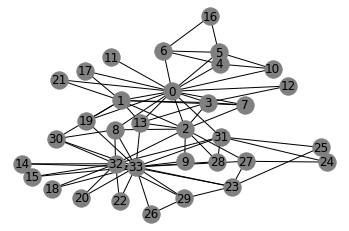

In [13]:
print('%d nodes.' % G.number_of_nodes())
print('%d edges.' % G.number_of_edges())

fig, ax = plt.subplots()
fig.set_tight_layout(False)
nx_G = G.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[0.5, 0.5, 0.5]])
plt.show()

In [14]:
G.ndata

{}

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

embed = nn.Embedding(34, 6)  # 34 nodes with embedding dim equal to 5
G.ndata['features'] = embed.weight

In [16]:
# print out node 2's input feature
print(G.ndata['features'][2])

# print out node 10 and 11's input features
print(G.ndata['features'][[10, 11]])

tensor([ 0.8699, -0.9791, -0.1740,  0.0054, -0.1956,  1.6902],
       grad_fn=<SelectBackward>)
tensor([[-1.2825e+00, -5.9394e-01,  1.6125e+00, -2.6941e-01,  1.6178e+00,
         -1.6795e-04],
        [-4.2466e-01, -1.0495e+00, -1.5526e+00, -8.2935e-01,  5.6896e-01,
          1.5985e+00]], grad_fn=<IndexBackward>)


In [0]:
from dgl.nn.pytorch import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# The first layer transforms input features of size of 6 to a hidden size of 6.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(6, 6, 2)

In [0]:
inputs = embed.weight
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [24]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6531
Epoch 1 | Loss: 0.6120
Epoch 2 | Loss: 0.5732
Epoch 3 | Loss: 0.5303
Epoch 4 | Loss: 0.4879
Epoch 5 | Loss: 0.4467
Epoch 6 | Loss: 0.4065
Epoch 7 | Loss: 0.3677
Epoch 8 | Loss: 0.3312
Epoch 9 | Loss: 0.2973
Epoch 10 | Loss: 0.2658
Epoch 11 | Loss: 0.2362
Epoch 12 | Loss: 0.2088
Epoch 13 | Loss: 0.1836
Epoch 14 | Loss: 0.1604
Epoch 15 | Loss: 0.1394
Epoch 16 | Loss: 0.1206
Epoch 17 | Loss: 0.1037
Epoch 18 | Loss: 0.0888
Epoch 19 | Loss: 0.0757
Epoch 20 | Loss: 0.0644
Epoch 21 | Loss: 0.0547
Epoch 22 | Loss: 0.0465
Epoch 23 | Loss: 0.0395
Epoch 24 | Loss: 0.0336
Epoch 25 | Loss: 0.0287
Epoch 26 | Loss: 0.0245
Epoch 27 | Loss: 0.0211
Epoch 28 | Loss: 0.0182
Epoch 29 | Loss: 0.0157
Epoch 30 | Loss: 0.0137
Epoch 31 | Loss: 0.0120
Epoch 32 | Loss: 0.0105
Epoch 33 | Loss: 0.0093
Epoch 34 | Loss: 0.0083
Epoch 35 | Loss: 0.0074
Epoch 36 | Loss: 0.0067
Epoch 37 | Loss: 0.0060
Epoch 38 | Loss: 0.0055
Epoch 39 | Loss: 0.0050
Epoch 40 | Loss: 0.0046
Epoch 41 | Loss: 0.0042
Ep

In [25]:
(all_logits[0])

tensor([[ 0.1100,  0.2972],
        [ 0.0492,  0.0949],
        [-0.1493,  0.1165],
        [ 0.0188,  0.1864],
        [-0.0613,  0.3787],
        [-0.0234,  0.3095],
        [ 0.1199, -0.1173],
        [ 0.0197,  0.0584],
        [-0.1585,  0.1554],
        [-0.0442,  0.1600],
        [ 0.1042, -0.1141],
        [-0.0237, -0.0473],
        [ 0.0350, -0.0369],
        [-0.0320,  0.1019],
        [-0.2321,  0.2253],
        [-0.2321,  0.2253],
        [ 0.1111,  0.2132],
        [-0.0582,  0.0046],
        [-0.2321,  0.2253],
        [-0.1116,  0.0678],
        [-0.2321,  0.2253],
        [-0.0582,  0.0046],
        [-0.2321,  0.2253],
        [-0.2004,  0.1246],
        [-0.0596, -0.0049],
        [-0.0577,  0.1051],
        [-0.0908,  0.0583],
        [-0.0808,  0.2026],
        [-0.0366,  0.1323],
        [-0.3418,  0.3313],
        [-0.2054,  0.1723],
        [-0.1734,  0.1414],
        [-0.1659,  0.0088],
        [-0.3020,  0.0929]])

In [0]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib inline

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

In [0]:
fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(49)  # draw the prediction of the first epoch
plt.close()

In [0]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)

In [43]:
from matplotlib import rc
rc('animation', html='jshtml')
ani